# Age Classifier using Deep CNNs  - 

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with long age span (range from **0 to 116 years old**). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, I have used the **aligned and cropped** faces available to train my models. Needless to say, any face input for testing must be cropped and aligned vertically to large extent.

#### Working Methodology - 

* For this task, I chose to have my own age classes. I divided the images into 5 groups in intervals of 25 - (0-24, 25-49 ....).

* I initially tried all 3 fundamental convolutional layers - `Conv2D`, `SeperableConv2D` and `Conv2DTranspose`. I found `SeperableConv2D` to perform the best. Then I tried using some key arguments of it and noted down its results.
Finally, for the best among those, I tested the performance of my models on 4 of the most popular and promising optimizers Keras has - **Adam**, **Adamax**, **SGD**, **Nadam**.

In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
dataset_folder_name = '/content/drive/My Drive/Images'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...
1,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170102...
2,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170102...
3,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170103...
4,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...


## Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23708 entries, 0 to 23710
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23708 non-null  float64
 1   gender  23708 non-null  object 
 2   race    23708 non-null  object 
 3   file    23708 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.1+ KB


In [ ]:
df.describe()
# Lower percentile - 25, median - 50, upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.300363
std,19.884509
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


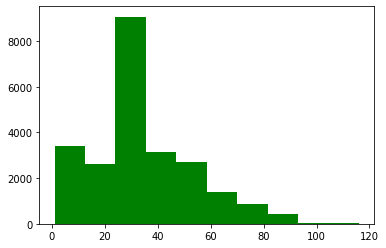

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()
# Majority population lies between 20-30 age group. Clearly, 
# the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be
# biased. Try using class weights

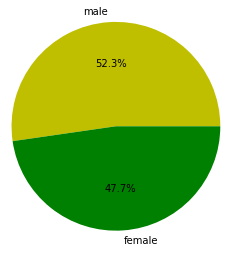

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()
# Uniform distribution to a large extent. Although, males slightly exceed females 
# in numbers.No need to change gender in data. Pretty well balanced !
# Lets also visualize this on a bar graph (to get better understanding of numbers)

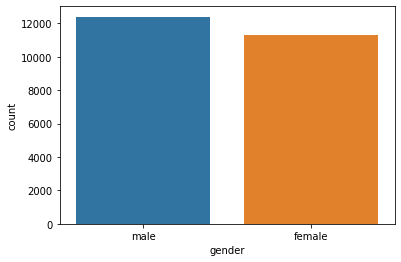

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.678186
male,35.694046


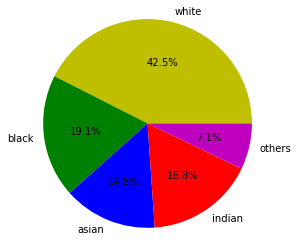

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.978276


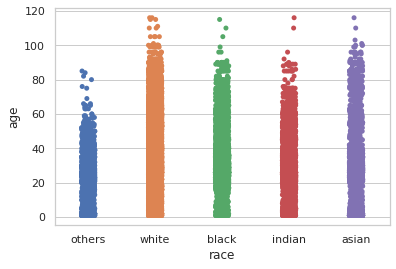

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) 
# in others category are present 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


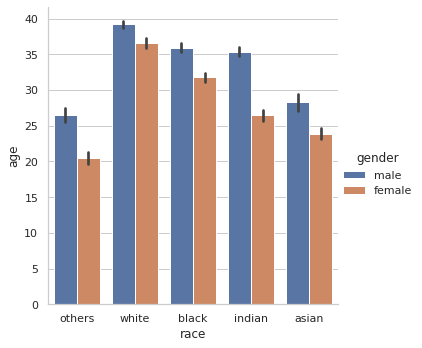

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

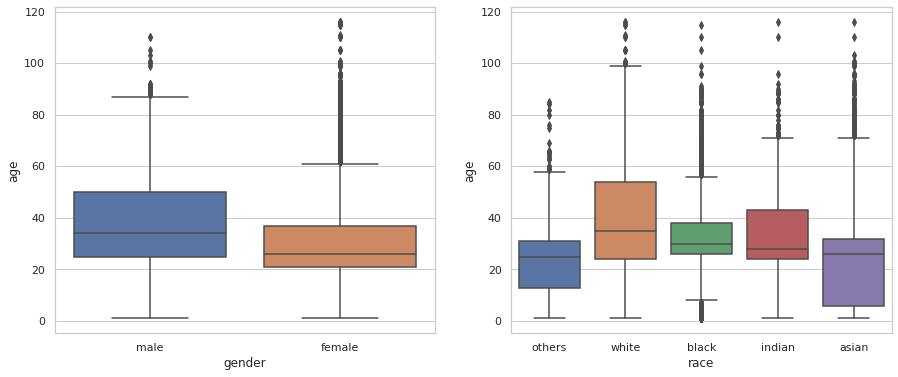

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

I would be working on the same set of images that I have used in other 2 notebooks (**Age Estimation** & **Gender Classifier**. So, let me load the dataset first.

In [ ]:
train_idx = np.load('/content/drive/My Drive/train_idx.npy') 
val_idx = np.load('/content/drive/My Drive/val_idx.npy')
test_idx = np.load('/content/drive/My Drive/test_idx.npy') 

In [ ]:
print(train_idx.size)         # ~~ 81 %
print(val_idx.size)           # ~~ 9 %
print(test_idx.size)          # ~~ 10 %

19203
2134
2371


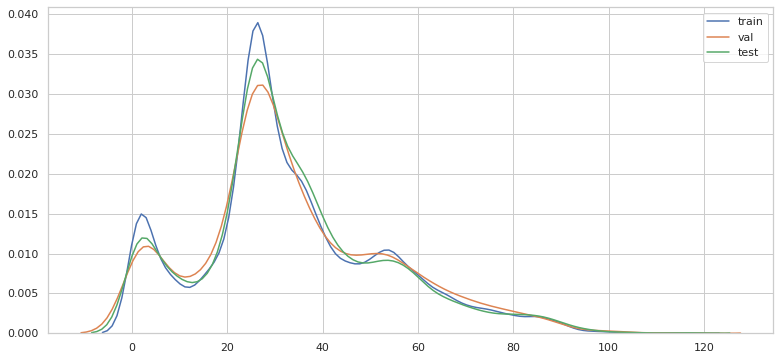

' We see that the distribution for train, test, val each is roughly the same. So \nit using such a division of data is acceptable '

In [ ]:
y=[]
z=[]
a=[]
for i in range(len(train_idx)):
    x = train_idx[i]
    y.append(int(df[x:x+1]['age']))

for i in range(len(val_idx)):
    x = val_idx[i]
    z.append(int(df[x:x+1]['age']))

for i in range(len(test_idx)):
    x = test_idx[i]
    a.append(int(df[x:x+1]['age']))
  
plt.figure(figsize=(13,6))
sns.kdeplot(y, label='train', gridsize=100)
sns.kdeplot(z, label='val',  gridsize=100)
sns.kdeplot(a, label='test', gridsize=100)
plt.show()

''' We see that the distribution for train, test, val each is roughly the same. So 
it using such a division of data is acceptable '''

In [ ]:
print(test_idx.size + train_idx.size + val_idx.size)

23708


23708 was the total number of images in dataset. We have put each image in 1 of the 3 compartments (train / test / val)

In [ ]:
''' Generates classes
0-24  -----> 0
25-49 -----> 1
49-74 -----> 2
75-99 -----> 3
100-124 -----> 4 '''

df['age'] = df['age']//25

x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)


6903   11818   3988   967   32   0


In [ ]:
from keras.utils import to_categorical
from PIL import Image
         
def preprocess_image(img_path):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    im = Image.open(img_path)
    im = im.resize((180, 180))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):
    """
    Used to generate a batch with images when training/testing/validating our Keras model.
    """
    
    # arrays to store our batched data
    images, ages = [], []
    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            file = person['file']
            
            im = preprocess_image(file)

            ages.append(to_categorical(age, 5))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), np.array(ages)
                images, ages = [], []
                
        if not is_training:
            break
            

## Model Architecture

This is the best model architecture I found for age classification. It was arrived at after trying many other models such as `Conv2D`, `Conv2DTranspose`. Even in `SeperableConv2D`, I tried it's including/not including it's different arguments such as *kernel_initializer*, *kernel_constraint*, etc.

**NOTE:** All results below, have been obtained once I verified that performance was not improving. I stopped training then, otherwise the model would overfit and lose its generalization ability.

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input


input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same",  kernel_initializer='he_uniform')(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.25)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.25)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same", kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.25)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128 , kernel_initializer='he_uniform' )(x)
x = Activation("relu")(x)
x = Dropout(0.35)(x)
x = BatchNormalization()(x)

x = Dense(64 , kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Dense(5, kernel_initializer='he_uniform')(x)
x = Activation("softmax")(x)           

age_model = Model(inputs=inputs, outputs=x)

## ADAM Optimizer 

### Model training - 



In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.005
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=30  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/30
600/600 [==============================] - 201s 335ms/step - loss: 1.1665 - accuracy: 0.5009 - val_loss: 1.5319 - val_accuracy: 0.4839
Epoch 2/30
600/600 [==============================] - 197s 329ms/step - loss: 0.9681 - accuracy: 0.5877 - val_loss: 0.9545 - val_accuracy: 0.6373
Epoch 3/30
600/600 [==============================] - 198s 329ms/step - loss: 0.8367 - accuracy: 0.6443 - val_loss: 0.8064 - val_accuracy: 0.6728
Epoch 4/30
600/600 [==============================] - 197s 329ms/step - loss: 0.7569 - accuracy: 0.6730 - val_loss: 0.9825 - val_accuracy: 0.6714
Epoch 5/30
600/600 [==============================] - 197s 329ms/step - loss: 0.7184 - accuracy: 0.6872 - val_loss: 1.0225 - val_accuracy: 0.7064
Epoch 6/30
600/600 [==============================] - 197s 328ms/step - loss: 0.6902 - accuracy: 0.7037 - val_loss: 0.6038 - val_accuracy: 0.6937
Epoch 7/30
600/600 [==============================] - 197s 328ms/step - loss: 0.6804 - accuracy: 0.7093 - val_loss: 0.4981 -

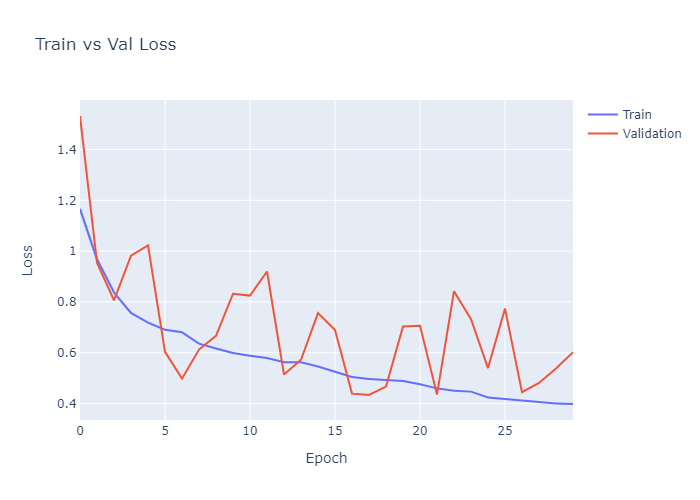

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

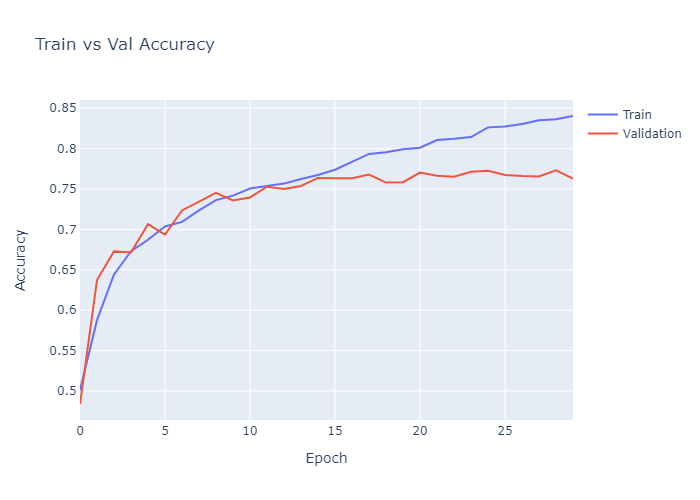

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

Performance has very much saturated. I found that even on training more or changing the model architecture, this was the best performance i could get on the validation set. So, lemme save my model for future use/deployment.

In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_ADAM')
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_ADAM.h5')

# Saving the above run model.

### Model testing -

In [ ]:
print(test_idx)
a = []
for i in test_idx:
    x = df.iloc[i]['age']
    a.append(x)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = age_model.predict_generator(test_generator, steps = 2371)

print(results.size)       # it gets multiplied by 5 here for there are 5 entries per entry of the list results
print('')
print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

11855

[[4.9610745e-02 9.4210356e-01 8.2180267e-03 6.1267958e-05 6.3988532e-06]
 [1.3901917e-02 9.7665262e-01 9.4115101e-03 3.2516189e-05 1.3826767e-06]
 [9.4720978e-01 5.2075651e-02 6.8400364e-04 2.0406986e-05 1.0269070e-05]
 ...
 [7.0611015e-02 9.1751665e-01 1.1661011e-02 1.8395335e-04 2.7337217e-05]
 [9.9925596e-01 7.4359978e-04 4.5370084e-07 2.4611995e-09 5.3144622e-09]
 [8.7378621e-01 1.2609465e-01 1.1579628e-04 1.4208439e-06 1.9779927e-06]]


Because of the format of the result, we cannot use model.evaluate directly to calculate the performance on test set. We must do that manually, which has been done below :)

In [ ]:
b = []
for i in results:
    max=-1
    for j in range(5):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 1, 0, 0, 0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 1, 3, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 3, 1, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 1, 3, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 

In [ ]:
print(len(b),' ',len(a))

# a - Actual age class in the dataset
# b - Predicted class by my model

''' PREDICTED CLASS - 
0 - 0-24
1 - 25-49
2 - 50-74
3 - 75-99
4 - 100-124 '''

2371   2371


In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.7912273302404049


## ADAMAX Optimizer 

### Model training -

In [ ]:
from keras.optimizers import Adamax
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.005
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adamax(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=30  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/30
600/600 [==============================] - 8370s 14s/step - loss: 1.2281 - accuracy: 0.4857 - val_loss: 1.2908 - val_accuracy: 0.4493
Epoch 2/30
600/600 [==============================] - 135s 225ms/step - loss: 0.9986 - accuracy: 0.5731 - val_loss: 0.8740 - val_accuracy: 0.6009
Epoch 3/30
600/600 [==============================] - 135s 225ms/step - loss: 0.8410 - accuracy: 0.6455 - val_loss: 0.8053 - val_accuracy: 0.6813
Epoch 4/30
600/600 [==============================] - 139s 231ms/step - loss: 0.7696 - accuracy: 0.6740 - val_loss: 0.8274 - val_accuracy: 0.7112
Epoch 5/30
600/600 [==============================] - 138s 231ms/step - loss: 0.7202 - accuracy: 0.6917 - val_loss: 1.0332 - val_accuracy: 0.7031
Epoch 6/30
600/600 [==============================] - 137s 228ms/step - loss: 0.6861 - accuracy: 0.7046 - val_loss: 0.4938 - val_accuracy: 0.7287
Epoch 7/30
600/600 [==============================] - 137s 228ms/step - loss: 0.6588 - accuracy: 0.7193 - val_loss: 0.4146 - 

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

The `lr` at the end of above training was 0.00108. It seems this is too much at that stage of the training. Probably that's why the model ain't learning . Let's train some more by manually resetting the learning to 0.0005. Hopefully the performance will improve :)

In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_ADAMAX')
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_ADAMAX.h5')

# Saving the above run model. 

In [ ]:
from keras.optimizers import Adamax
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.0005
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adamax(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=15  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/15
600/600 [==============================] - 142s 237ms/step - loss: 0.3737 - accuracy: 0.8466 - val_loss: 0.4098 - val_accuracy: 0.7675
Epoch 2/15
600/600 [==============================] - 137s 229ms/step - loss: 0.3646 - accuracy: 0.8536 - val_loss: 0.5158 - val_accuracy: 0.7647
Epoch 3/15
600/600 [==============================] - 137s 228ms/step - loss: 0.3575 - accuracy: 0.8552 - val_loss: 0.9216 - val_accuracy: 0.7666
Epoch 4/15
600/600 [==============================] - 135s 225ms/step - loss: 0.3518 - accuracy: 0.8592 - val_loss: 1.0433 - val_accuracy: 0.7708
Epoch 5/15
600/600 [==============================] - 134s 224ms/step - loss: 0.3408 - accuracy: 0.8639 - val_loss: 1.1745 - val_accuracy: 0.7741
Epoch 6/15
600/600 [==============================] - 134s 224ms/step - loss: 0.3280 - accuracy: 0.8718 - val_loss: 0.4500 - val_accuracy: 0.7699
Epoch 7/15
600/600 [==============================] - 134s 223ms/step - loss: 0.3172 - accuracy: 0.8763 - val_loss: 0.2689 -

### Model testing - 

In [ ]:
print(test_idx)
a = []
for i in test_idx:
    x = df.iloc[i]['age']
    a.append(x)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = age_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[3.6346611e-02 9.5792013e-01 5.6855110e-03 4.0069299e-05 7.6380311e-06]
 [5.8381595e-03 9.9341089e-01 7.4834516e-04 2.1599749e-06 4.8936266e-07]
 [9.9444711e-01 5.4600127e-03 5.4489428e-05 1.9145602e-05 1.9202454e-05]
 ...
 [9.2557883e-03 9.8233140e-01 8.3630932e-03 4.5679815e-05 4.0077639e-06]
 [9.9983430e-01 1.6503622e-04 8.4708518e-08 5.8631343e-08 4.4995068e-07]
 [9.5462483e-01 4.5242604e-02 1.0370430e-04 9.3598419e-06 1.9489120e-05]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(5):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 1, 3, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 2, 1, 3, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.7950231969633066


## SGD Optimizer

### Model training -  

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.005
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=30  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/30
600/600 [==============================] - 140s 233ms/step - loss: 1.5864 - accuracy: 0.3610 - val_loss: 1.3144 - val_accuracy: 0.4777
Epoch 2/30
600/600 [==============================] - 136s 226ms/step - loss: 1.2600 - accuracy: 0.4781 - val_loss: 1.1282 - val_accuracy: 0.5123
Epoch 3/30
600/600 [==============================] - 136s 226ms/step - loss: 1.1797 - accuracy: 0.5001 - val_loss: 1.2600 - val_accuracy: 0.5166
Epoch 4/30
600/600 [==============================] - 137s 228ms/step - loss: 1.1420 - accuracy: 0.5132 - val_loss: 1.2727 - val_accuracy: 0.4882
Epoch 5/30
600/600 [==============================] - 136s 226ms/step - loss: 1.1229 - accuracy: 0.5165 - val_loss: 1.1691 - val_accuracy: 0.5331
Epoch 6/30
600/600 [==============================] - 136s 226ms/step - loss: 1.1058 - accuracy: 0.5264 - val_loss: 0.9930 - val_accuracy: 0.5388
Epoch 7/30
600/600 [==============================] - 136s 226ms/step - loss: 1.0808 - accuracy: 0.5302 - val_loss: 0.9954 -

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

From the graph it's evident that the **SGD** helps a model learn incredibly slowly - not just by validation by even training performance.
Compare this graph by other graphs of **Adam** or **Adamax** above. 

Let's train with a much lowere `lr`. Maybe this move could assist **SGD** converge much better.

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.0006
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=30  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/30
600/600 [==============================] - 137s 228ms/step - loss: 0.8571 - accuracy: 0.6421 - val_loss: 0.7135 - val_accuracy: 0.6690
Epoch 2/30
600/600 [==============================] - 134s 224ms/step - loss: 0.8526 - accuracy: 0.6425 - val_loss: 0.7440 - val_accuracy: 0.6652
Epoch 3/30
600/600 [==============================] - 137s 229ms/step - loss: 0.8469 - accuracy: 0.6421 - val_loss: 0.8693 - val_accuracy: 0.6629
Epoch 4/30
600/600 [==============================] - 137s 228ms/step - loss: 0.8438 - accuracy: 0.6482 - val_loss: 0.8731 - val_accuracy: 0.6577
Epoch 5/30
600/600 [==============================] - 136s 227ms/step - loss: 0.8433 - accuracy: 0.6430 - val_loss: 0.9960 - val_accuracy: 0.6747
Epoch 6/30
600/600 [==============================] - 135s 225ms/step - loss: 0.8438 - accuracy: 0.6455 - val_loss: 0.8008 - val_accuracy: 0.6757
Epoch 7/30
600/600 [==============================] - 135s 225ms/step - loss: 0.8393 - accuracy: 0.6443 - val_loss: 0.6988 -

Hardly any growth ! **SGD** indeed struggles to minimize the loss function, thereby improving saturating the model performance early in the training.

### Model testing - 

In [ ]:
print(test_idx)
a = []
for i in test_idx:
    x = df.iloc[i]['age']
    a.append(x)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = age_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[1.5885425e-01 7.7042323e-01 6.3742422e-02 5.2397642e-03 1.7402609e-03]
 [1.4027834e-01 7.2196048e-01 1.1966296e-01 1.5489471e-02 2.6087882e-03]
 [3.5293442e-01 4.7570735e-01 1.3927372e-01 2.7850306e-02 4.2342050e-03]
 ...
 [4.0456682e-01 5.1050818e-01 6.8377510e-02 1.3587723e-02 2.9597878e-03]
 [9.6036899e-01 3.3542346e-02 3.8494265e-03 1.3149828e-03 9.2426233e-04]
 [2.1342142e-01 7.1621346e-01 6.2174950e-02 6.5971455e-03 1.5930454e-03]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(5):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.7001265288907634


## SGD optimizer with Momentum

### Model training - 

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.005
	drop = 0.6
	epochs_drop = 8.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0, momentum=0.9)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
256/600 [===========>..................] - ETA: 43:55 - loss: 1.3077 - accuracy: 0.4448

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


600/600 [==============================] - 4969s 8s/step - loss: 1.2069 - accuracy: 0.4860 - val_loss: 1.1798 - val_accuracy: 0.5024
Epoch 2/35
600/600 [==============================] - 125s 209ms/step - loss: 1.1163 - accuracy: 0.5172 - val_loss: 1.1636 - val_accuracy: 0.5303
Epoch 3/35
600/600 [==============================] - 126s 210ms/step - loss: 1.0922 - accuracy: 0.5294 - val_loss: 1.1315 - val_accuracy: 0.5478
Epoch 4/35
600/600 [==============================] - 125s 208ms/step - loss: 1.0606 - accuracy: 0.5456 - val_loss: 1.2845 - val_accuracy: 0.5317
Epoch 5/35
600/600 [==============================] - 125s 208ms/step - loss: 1.0247 - accuracy: 0.5612 - val_loss: 1.0586 - val_accuracy: 0.5885
Epoch 6/35
600/600 [==============================] - 124s 206ms/step - loss: 0.9876 - accuracy: 0.5800 - val_loss: 0.8900 - val_accuracy: 0.5862
Epoch 7/35
600/600 [==============================] - 124s 206ms/step - loss: 0.9368 - accuracy: 0.6084 - val_loss: 0.9049 - val_accuracy

Upon training more, the model would simply overfit.

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

### Model testing - 

In [ ]:
print(test_idx)
a = []
for i in test_idx:
    x = df.iloc[i]['age']
    a.append(x)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = age_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[3.18907142e-01 6.74343944e-01 6.55077677e-03 1.76641974e-04
  2.14512038e-05]
 [1.33264765e-01 8.55760634e-01 1.08196689e-02 1.38977703e-04
  1.60074433e-05]
 [6.19431674e-01 3.70075196e-01 9.84568242e-03 5.81247150e-04
  6.61543236e-05]
 ...
 [2.41605967e-01 7.35718071e-01 2.19703484e-02 6.53267780e-04
  5.23824965e-05]
 [9.89287615e-01 1.06034195e-02 8.29557030e-05 1.92011594e-05
  6.82975588e-06]
 [4.10161138e-01 5.83957851e-01 5.65152010e-03 2.06514349e-04
  2.30104652e-05]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(5):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 1, 2, 1, 3, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.7709827077182624


In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_SGD_with_M')
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_SGD_with_M.h5')

# Saving the above run model. 

## NADAM Optimizer

### Model training -  

In [ ]:
from keras.optimizers import Nadam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.6
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Nadam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = age_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
600/600 [==============================] - 135s 225ms/step - loss: 1.1480 - accuracy: 0.5098 - val_loss: 2.0829 - val_accuracy: 0.1823
Epoch 2/35
600/600 [==============================] - 132s 220ms/step - loss: 0.8887 - accuracy: 0.6212 - val_loss: 1.0160 - val_accuracy: 0.5554
Epoch 3/35
600/600 [==============================] - 133s 222ms/step - loss: 0.7828 - accuracy: 0.6675 - val_loss: 0.7952 - val_accuracy: 0.6974
Epoch 4/35
600/600 [==============================] - 133s 221ms/step - loss: 0.7318 - accuracy: 0.6871 - val_loss: 0.9376 - val_accuracy: 0.6757
Epoch 5/35
600/600 [==============================] - 133s 222ms/step - loss: 0.6982 - accuracy: 0.7000 - val_loss: 0.9183 - val_accuracy: 0.7159
Epoch 6/35
600/600 [==============================] - 133s 222ms/step - loss: 0.6730 - accuracy: 0.7081 - val_loss: 0.7017 - val_accuracy: 0.6757
Epoch 7/35
600/600 [==============================] - 133s 222ms/step - loss: 0.6454 - accuracy: 0.7242 - val_loss: 0.5166 -

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
print(test_idx)
a = []
for i in test_idx:
    x = df.iloc[i]['age']
    a.append(x)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = age_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[4.84175906e-02 9.51281667e-01 2.98797095e-04 1.21440405e-06
  6.24837298e-07]
 [8.08418170e-03 9.90751207e-01 1.16399326e-03 5.84693055e-07
  6.85935788e-08]
 [9.82987404e-01 1.69810224e-02 2.98543673e-05 1.01559203e-06
  8.73974329e-07]
 ...
 [2.50823162e-02 9.71551836e-01 3.34931631e-03 1.41269711e-05
  2.35338825e-06]
 [9.96180773e-01 3.81884724e-03 4.10134419e-07 5.27120436e-09
  2.50869068e-08]
 [9.33712244e-01 6.61756098e-02 1.04940336e-04 4.15858449e-06
  3.08726362e-06]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(5):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 1, 0, 0, 0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 0, 2, 0, 0, 1, 0, 3, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 0, 3, 1, 2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 3, 0, 1, 3, 2, 2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 3, 0, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 2, 1, 1, 3, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 1, 3, 2, 1, 0, 2, 1, 2, 1, 0, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.7840573597638127


In [ ]:
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_NADAM')
age_model.save('/content/drive/My Drive/Colab Notebooks/AC_NADAM.h5')

# Saving the above run model. It has performed best till date.

Our best model is able to predict classes with accuracy of **79.502 %**  on the test set. Don't forget that although the test set is from the same dataset (and hence the same distribution), model has not seen a single image from it.

**This tells us that the model has the ability to generalize well to unseen images (provided they are from right distribution)**

## Testing on some external images (using best model of the above) .
Have a look at some correctly classified images !

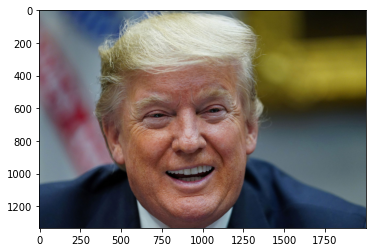

[[5.6565800e-03 2.7235270e-01 6.9180596e-01 2.9796371e-02 3.8837577e-04]]

50-74 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/b.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

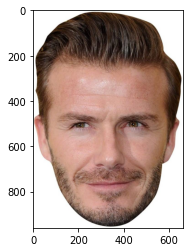

[[0.13806064 0.53531843 0.29372793 0.03189509 0.00099786]]

25-49 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/beck.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

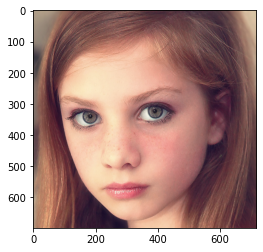

[[8.7411124e-01 7.5446561e-02 4.3464832e-02 6.4461953e-03 5.3113350e-04]]

0-24 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/teen1.png"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

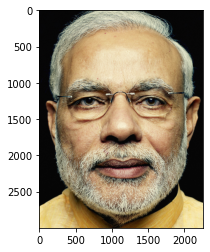

[[0.00664527 0.02812541 0.4827398  0.4650189  0.01747055]]

50-74 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/modi.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

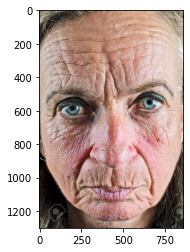

[[0.01354864 0.01231176 0.2963753  0.6320303  0.04573395]]

75-99 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/old_w.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

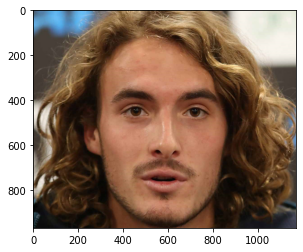

[[0.9000661  0.02024402 0.05026622 0.02685043 0.00257332]]

0-24 yrs old


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/tsit.jpg"                                     
age_pred = age_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

max=-1
count=0
for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1
print(age_pred)
print('')
if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')